# Cleaning ABES extraction 

Ce notebook permet de vérifier l'extraction de données réalisée par l'ABES et d'enlever les notices potentiellement mal formattées (du fait de correspondance entre les métadonnées de la notice et le type de séparateur choisi par exemple).
Une étape de mise à plat des chaines d'indexation est également réalisée ainsi qu'une première exploration des concepts RAMEAU et labels TEF (issus de la classification décimale de DEWEY) sous forme de visualisation graphique (barplots et wordcloud)

MAJ - 03/05/2023 (Aurélie Thébault - EcoStats)

# Set project

### Packages

In [137]:
# Import librairies
import os
import re
import sys

import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from collections import Counter
from wordcloud import WordCloud

from utils_text_processing import *
from utils_visualization import *

In [138]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

### Graphical parameters

In [139]:
# Parametres graphiques
%matplotlib inline
rc = {
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(font='Arial', rc=rc)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': True,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })
sns.set_context(
    "notebook",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})
pd.set_option('display.max_columns', None)

### Paths

In [140]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
output_path = path + "/outputs"
fig_path = path + "/figs"

### Useful functions

In [141]:
def import_data(filename, encoding="utf-8", plot=False):
    with open(
        os.path.join(data_path, filename), 'r',
            newline='', encoding=encoding) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t',)
        data = list(csv_reader)

        return data

In [142]:
class checkDataFormat:
    def __init__(self, df_list):
        self.df = df_list

    def check_format(self, plot=False):
        # Define dimension
        df = self.df

        nb_notice = len(df)

        # Check number of column
        len_col = []
        for row in df:
            len_col.append(len(row))
        max_number_col = max(len_col)
        print(f"There are {nb_notice} in this file with till {max_number_col} columns")

        if plot:
            # Show distribution
            sns.histplot(len_col)

        self.nb_notice = nb_notice
        self.max_number_col = max_number_col
        self.len_col = len_col

    def sort_notices(self, official_nb_col=5, save_file="working_data.pkl", export_name=None):
        
        # Checking and removing badly formatted notices
        len_col = self.len_col
        df = self.df

        bad_formated_notices = [x for x in len_col if x != official_nb_col]
        print(f"There are {len(bad_formated_notices)} badly formatted notices")

        ids_to_keep = [True if x == official_nb_col else False for x in len_col]
        print(f"There are {sum(ids_to_keep)-1} well formatted rows")

        cleaned_data = [row for row, id in zip(df, ids_to_keep) if id]
        cleaned_data = pd.DataFrame(cleaned_data[1:], columns=cleaned_data[0])
        print(f" ==> Working dataset has {len(cleaned_data)} notices")

        # Verification du format des données
        print(f"Cleaned file contains {cleaned_data.shape[0]} notices and  {cleaned_data.shape[1]} columns")

        data_to_check = [row for row, id in zip(df, ids_to_keep) if not id]
        data_to_check = pd.DataFrame(data_to_check)
        print(f"Need to check {len(data_to_check)} notices extractions")

        # Sauvegarde des données
        if save_file.endswith("csv"):
            cleaned_data.to_csv(
                os.path.join(data_path, save_file))
            print(f"Save working data as {save_file}")
        elif save_file.endswith(("pkl", "pickle")):
            cleaned_data.to_pickle(
                os.path.join(data_path, save_file))
            print(f"Save working data as {save_file}")
        else:
            print("saved files must be .csv or .pickle")
        

        if export_name:
        # Export des données à vérifier
            if save_file.endswith("csv"):
                data_to_check.to_csv(
                    os.path.join(data_path, export_name))
                print(f"Save data to check data as {export_name}")            
            elif save_file.endswith(("pkl", "pickle")):
                data_to_check.to_pickle(
                    os.path.join(data_path, export_name))
                print(f"Save data to check data as {export_name}")
            else:
                print("Saved files must be .csv or .pickle")
                

In [143]:
class removeVedettes:
    def __init__(self, df, col_name, vedette_list):
        self.df = df
        self.col_name = col_name
        self.vedettes = vedette_list

    def remove_vedette(self):
        df = self.df
        col = self.col_name
        vedettes = self.vedettes

        is_ved = np.zeros(df.shape[0])
        for ved in vedettes:
            res = df[col].apply(lambda x: ved in x)
            print(f"Nbre de notices contenant le concept '{ved}' : {sum(res)}")
            is_ved += res

        # Reduction du jeu de données
        df_reduced = self.df[(is_ved) == 0]
        print(f"Les vedettes de {vedettes} ont été retirées du dataset")
        print(f"Le dataset contient maintenant {df_reduced.shape[0]} notices")

        self.df_reduced = df_reduced

In [144]:
def get_domain_from_ddc(ddc):
    # Get Domain according to Dewey code
    pattern_tenth = re.compile(r'\d{2}0|00[0-9]|944|796')
    pattern_unit= re.compile(r'\d{2}[1-9]')
    if re.findall(pattern_tenth, ddc):
        tef = str(re.findall(pattern_tenth, ddc)[0])
    elif re.findall(pattern_unit, ddc):
        tef = str(re.findall(pattern_unit, ddc)[0][:-1] + str(0))
    else:
        tef = None
    return tef

# Import data

In [166]:
# Import des données
filepath = "extraction/export.dsv"
working_data_filename = "working_data.csv"
export_data_filename = "data_to_check.csv"
encoding = "latin-1"  # (useful only on first extraction)
data = import_data(filepath, encoding)
filename = filepath.split('/')[-1].split('.')[0]
merge_with_dewey = True

In [146]:
# Import des données
filepath = "extraction/export_sans_dewey.dsv"
working_data_filename = "working_data_sans_dewey.csv"
export_data_filename = "data_to_check_sans_dewey.csv"
# encoding = "latin-1"  # (useful only on first extraction)
data = import_data(filepath)#, encoding)
filename = filepath.split('/')[-1].split('.')[0]
merge_with_dewey = False

In [167]:
# Clean file
df = checkDataFormat(data)
df.check_format()
df.sort_notices(
    save_file=working_data_filename,
    export_name=export_data_filename)

There are 89435 in this file with till 7 columns
There are 18 badly formatted notices
There are 89416 well formatted rows
 ==> Working dataset has 89416 notices
Cleaned file contains 89416 notices and  5 columns
Need to check 18 notices extractions
Save working data as working_data.csv
Save data to check data as data_to_check.csv


In [168]:
# Load working data
if working_data_filename.endswith(("pkl", "pickle")):
    df = pd.read_pickle(os.path.join(data_path, working_data_filename))
elif working_data_filename.endswith('csv'):
    df = pd.read_csv(os.path.join(data_path, working_data_filename), index_col=0)
print(f"Data loaded :", df.shape)

Data loaded : (89416, 5)


In [169]:
df

,PPN,TITRE,RESUME,RAMEAU,DEWEY
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830
...,...,...,...,...,...
89411,268339252,Le sentiment d'humanité : manifeste pour une f...,"« Mon enfant, ma fille, qu'est-ce qu'e^tre hum...",Humanité;Réalisation de soi,128
89412,268363072,La saga des trois petits pois,"Trois pois, Réal, Jean-Jacques et Donald, ont ...",Aliments -- Ouvrages pour la jeunesse;Pois (lé...,843/.914 D814s
89413,268365113,Droit de la représentation du personnel,"Présentation de l'éditeur : ""Le droit de la re...",Représentation du personnel,344.018
89414,268365334,Droit pénal social : droit pénal du travail et...,"Depuis deux siècles, la conjugaison de l'essor...",Droit pénal;Sécurité sociale -- Droit -- Dispo...,345.44


In [170]:
df.head()

,PPN,TITRE,RESUME,RAMEAU,DEWEY
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830


In [171]:
# Ajout d'une colonne description (Titre + resumé)
df.loc[:, "DESCR"] = df.loc[:, 'TITRE'] + ' ' + df.loc[:, 'RESUME']

# Explore RAMEAU

In [172]:
# Extraction des indices contenant " -- " dans la colonne RAMEAU => i.e chaines d'indexation
df["presence_chaine_indexation"] = df["RAMEAU"].apply(lambda x: True if re.search(' -- ', x) else False)
n_chaine_index = df["presence_chaine_indexation"].sum()
print(f"Le jeu de données contient {n_chaine_index} notices avec des chaines d'indexation")

Le jeu de données contient 39141 notices avec des chaines d'indexation


In [173]:
df.loc[df["presence_chaine_indexation"] == True, ["PPN", "RAMEAU"]]

,PPN,RAMEAU
4,000026352,Science-fiction américaine -- Traductions fran...
7,000039470,Tarots (cartes à jouer) -- Contes
9,000041416,Attachement;Mères et nourrissons;Personnalité ...
11,000049719,Civilisation -- Histoire
18,000062995,Professeurs des écoles -- Formation;Écoles nor...
...,...,...
89402,268319014,Art chrétien -- Peinture
89405,268334846,Préparation au mariage -- Église catholique
89412,268363072,Aliments -- Ouvrages pour la jeunesse;Pois (lé...
89414,268365334,Droit pénal;Sécurité sociale -- Droit -- Dispo...


In [174]:
# Extraction des chaines d'indexation
df["rameau_chaines_index"] = df["RAMEAU"].apply(lambda x: x.split(';'))
print(df.loc[1:10, "rameau_chaines_index"])

1         [Complexe de castration, Psychanalyse, Rêves]
2                                             [Culture]
3                                      [Structuralisme]
4     [Science-fiction américaine -- Traductions fra...
5                                        [Photographie]
6     [Agglomérations urbaines, Aménagement du terri...
7                   [Tarots (cartes à jouer) -- Contes]
8     [Allégorie de la caverne, Différences entre se...
9     [Attachement, Mères et nourrissons, Personnali...
10               [Philosophes, Philosophie et sciences]
Name: rameau_chaines_index, dtype: object


In [175]:
# Nombre de de notices d'autorité différentes (y compris pré-construites)
# ex d'autorité preconstruite : Science-fiction américaine -- Traductions française
from itertools import chain
rameau_chaine_index = df["rameau_chaines_index"].tolist()
rameau_list_chaines_index = list(chain(*rameau_chaine_index))
print(f"{len(rameau_list_chaines_index)} chaines d'indexation rameau, dont {len(set(rameau_list_chaines_index))} différentes")

200405 chaines d'indexation rameau, dont 52441 différentes


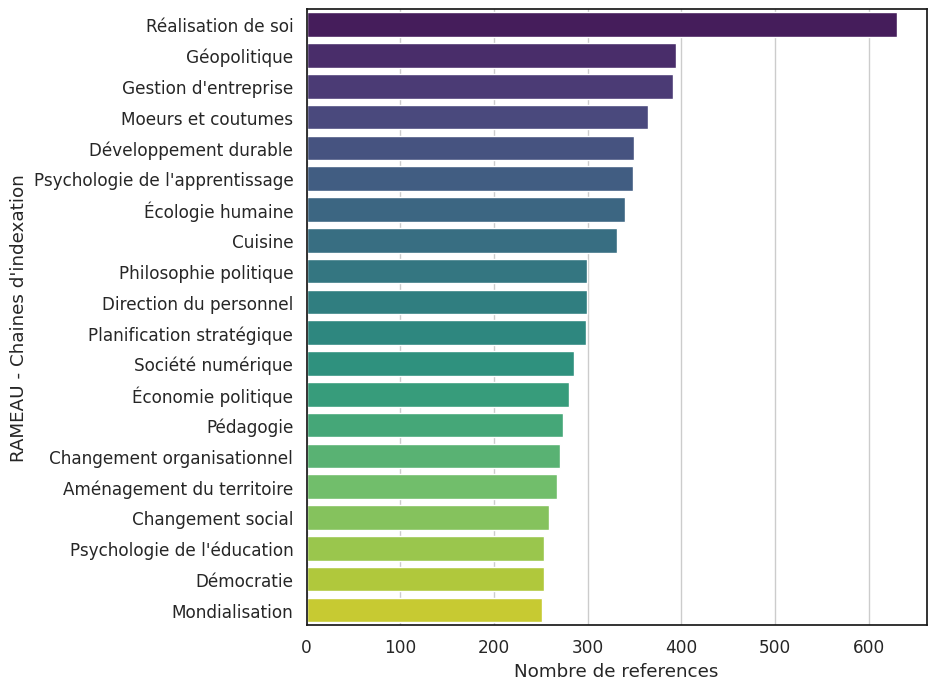

In [176]:
plot_barplot_of_tags(
    tags_list=rameau_list_chaines_index,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Chaines d'indexation",
    figsave=str(filename + "_" + 'barplot_Rameau_ChainesIndex.png'),
    figsize=(8, 8))

In [177]:
# Mettre à plat TOUS les mots clé
pattern = r';\s*(?![^()]*\))| -- '
df["rameau_concepts"] = df["RAMEAU"].apply(lambda x: re.split(pattern, x))
df.loc[1:20, ["RAMEAU", "rameau_concepts"]]

,RAMEAU,rameau_concepts
1,Complexe de castration;Psychanalyse;Rêves,"[Complexe de castration, Psychanalyse, Rêves]"
2,Culture,[Culture]
3,Structuralisme,[Structuralisme]
4,Science-fiction américaine -- Traductions fran...,"[Science-fiction américaine, Traductions franç..."
5,Photographie,[Photographie]
6,Agglomérations urbaines;Aménagement du territo...,"[Agglomérations urbaines, Aménagement du terri..."
7,Tarots (cartes à jouer) -- Contes,"[Tarots (cartes à jouer), Contes]"
8,Allégorie de la caverne;Différences entre sexe...,"[Allégorie de la caverne, Différences entre se..."
9,Attachement;Mères et nourrissons;Personnalité ...,"[Attachement, Mères et nourrissons, Personnali..."
10,Philosophes;Philosophie et sciences,"[Philosophes, Philosophie et sciences]"


In [178]:
keywords = flatten(df['rameau_concepts'])
print(f"Le dataset contient {len(set(keywords))} concepts RAMEAU differents")

Le dataset contient 21374 concepts RAMEAU differents


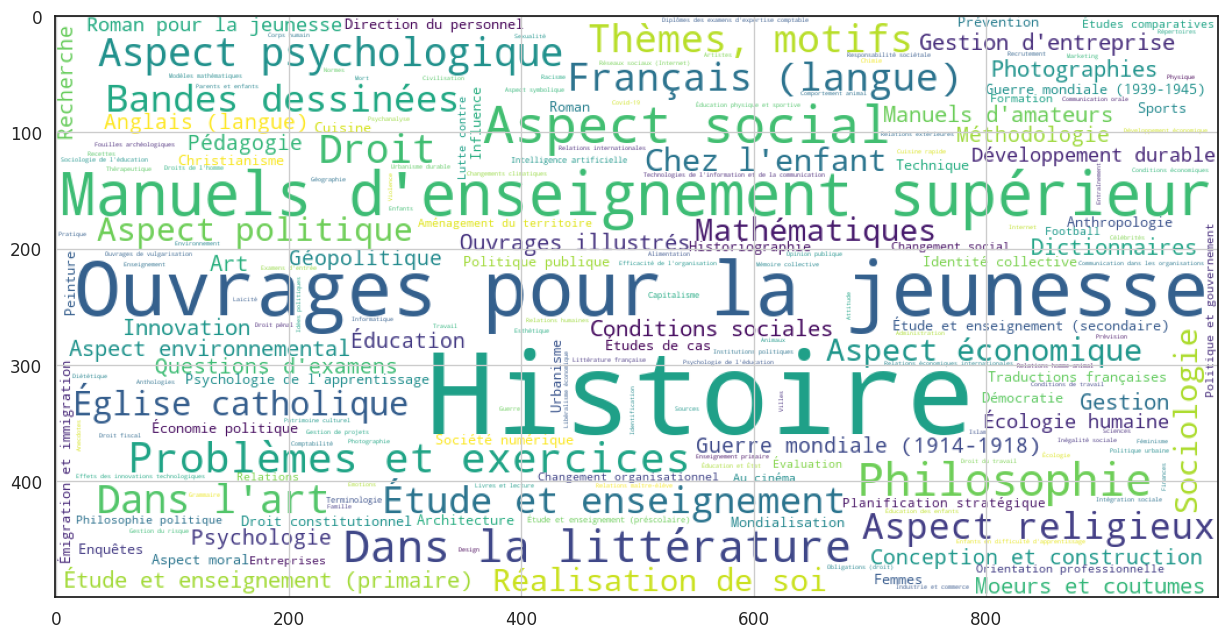

In [179]:
# Show main vedettes
plot_wordcloud(keywords, save_file=str(filename + "_" + "rameau_concepts_wordcloud.png"))

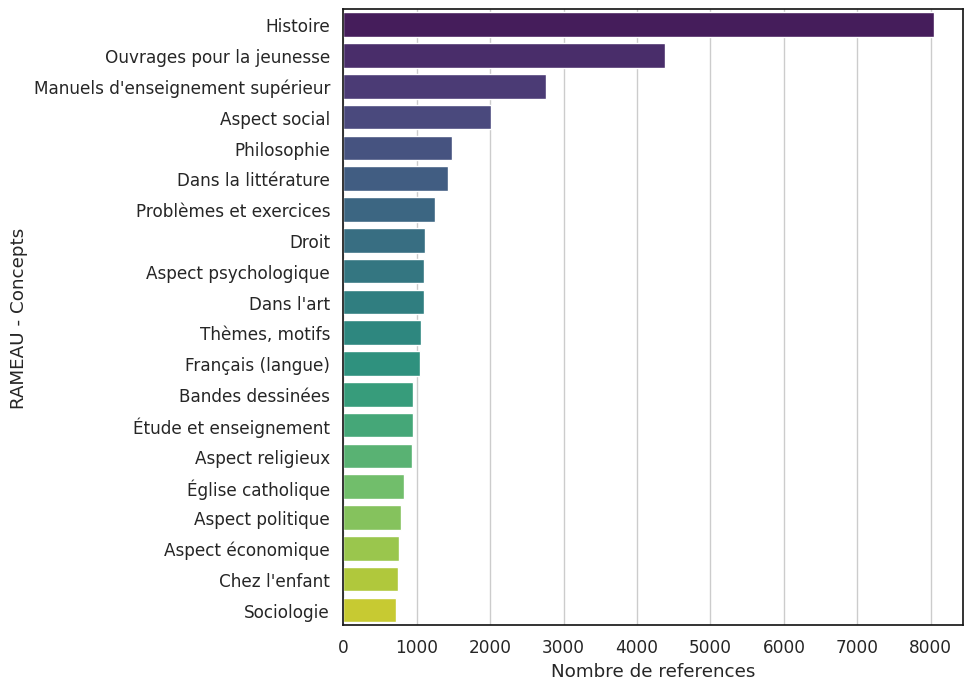

In [180]:
plot_barplot_of_tags(
    tags_list=keywords,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Concepts",
    figsave=str(filename + "_" + 'barplot_Rameau_concepts.png'),
    figsize=(8, 8))

### Remove vedettes

In [181]:
list_vedettes = ["Ouvrages pour la jeunesse", "Roman pour la jeunesse"]
colonne = "rameau_concepts"
temp = removeVedettes(df, colonne, list_vedettes)
temp.remove_vedette()

Nbre de notices contenant le concept 'Ouvrages pour la jeunesse' : 2916
Nbre de notices contenant le concept 'Roman pour la jeunesse' : 235
Les vedettes de ['Ouvrages pour la jeunesse', 'Roman pour la jeunesse'] ont été retirées du dataset
Le dataset contient maintenant 86283 notices


### Check cleaned file

In [182]:
# Dataset final
cleaned_df = temp.df_reduced
cleaned_df.shape

(86283, 9)

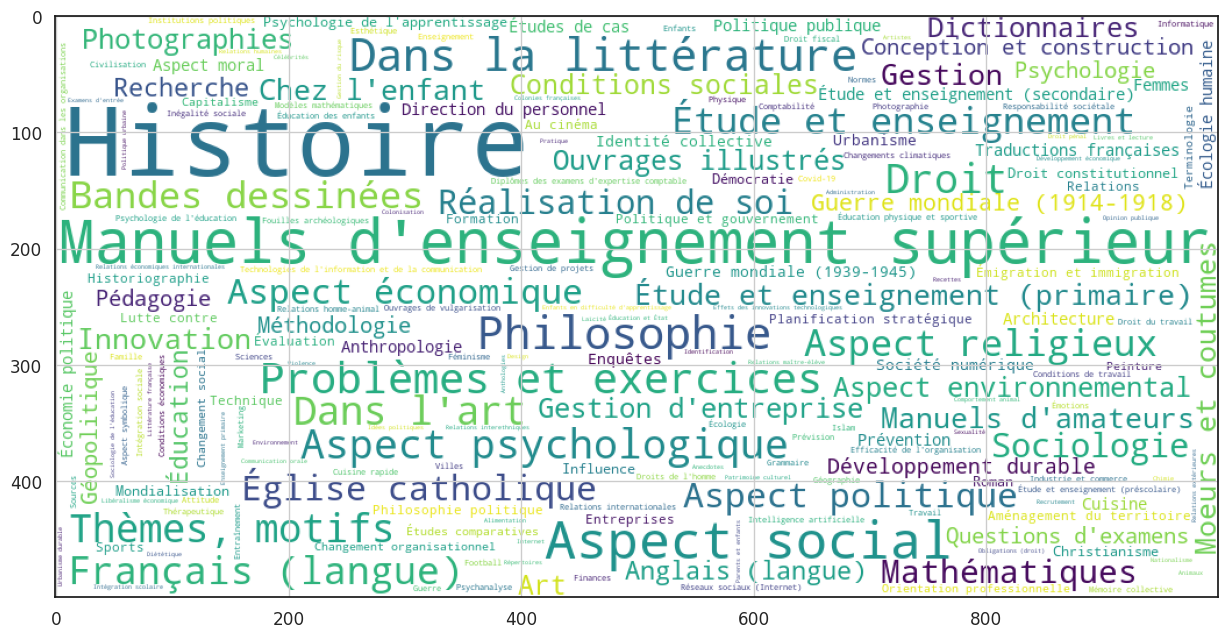

In [183]:
# Show main vedettes
keywords2 = flatten(cleaned_df['rameau_concepts'])
plot_wordcloud(keywords2, save_file=str(filename + "_" + "rameau_concepts_wordcloud_cleaned.png"))

### Explore Dewey

/tmp/ipykernel_561286/3241730176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["DDC"] = cleaned_df["DEWEY"].apply(lambda x: get_domain_from_ddc(x))


Dimension of the dataframe with TEF labels: (86283, 11)
Column headers:  ['PPN', 'TITRE', 'RESUME', 'RAMEAU', 'DEWEY', 'DESCR', 'presence_chaine_indexation', 'rameau_chaines_index', 'rameau_concepts', 'DDC', 'TEF_LABEL']


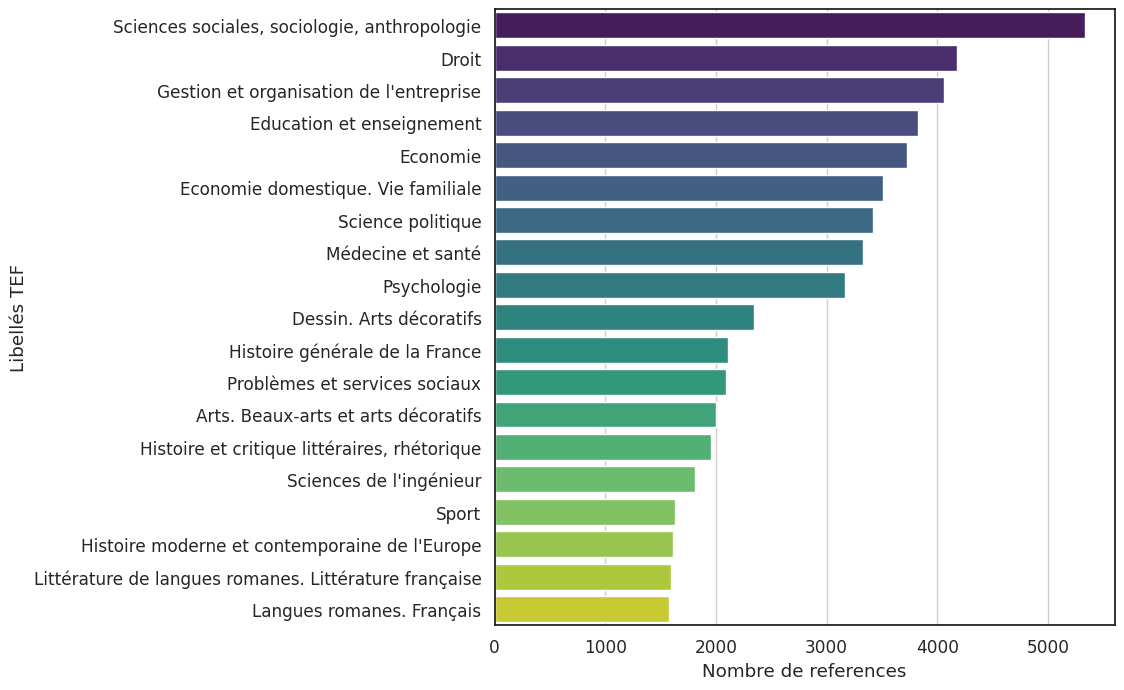

In [184]:
if merge_with_dewey:
    # Find DDC domain
    cleaned_df["DDC"] = cleaned_df["DEWEY"].apply(lambda x: get_domain_from_ddc(x))
    # Merge with TEF labels
    ddc = pd.read_csv(os.path.join(data_path, "dewey_label.csv"), index_col=0, dtype=str)

    # Merge 
    cleaned_df = cleaned_df.merge(ddc, on="DDC", how='left')
    print(f"Dimension of the dataframe with TEF labels: {cleaned_df.shape}")
    print("Column headers: ", list(cleaned_df.columns))

    # Visualization
    plot_barplot_of_tags(
        tags_list=cleaned_df["TEF_LABEL"],
        nb_of_tags=20,
        xlabel="Nombre de references",
        ylabel="Libellés TEF",
        figsave='barplot_libelles_TEF.png',
        figsize=(8, 8))

# Save working file as pickle

In [185]:
# Saving file
if working_data_filename.endswith(("pkl", "pickle")):
    cleaned_df.to_pickle(os.path.join(data_path, working_data_filename))
elif working_data_filename.endswith("csv"):
    cleaned_df.to_csv(os.path.join(data_path, working_data_filename))
else: 
    print("saved files must be .csv or .pickle")